# Mask R-CNN - Twitter following button detection

This notebook shows using Mask R-CNN to detect the Twitter following buttons. 

It is a simple task, but you'd still need a GPU. 

The image to detect looks like this:


<img src="./images/5.png" width = "400"/>


The training and validation datasets are based on 4 twitter following page screenshots similar to the above figure (as shown 1.png ~ 4.png in image folder). Randomly cut the figures into smaller ~ 50 images, and separated into training and validation datasets (as shown in datasets/train and datasets/val). The annotations (json format) are obtained using [VIA](http://www.robots.ox.ac.uk/~vgg/software/via/).

The image that we use to test is `datasets/test/5.jpg`

## Importing libraries, setting up path, and check pre-trained weights.

In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [5]:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
CURR_DIR = os.path.abspath("./")  # The directory of this project

# We are going to store the checkpoints and pre-trained weights in the project directory.
MODEL_DIR = os.path.join(CURR_DIR, "button_logs") 
COCO_MODEL_PATH = os.path.join(CURR_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


## Configurations

In [7]:
class ButtonConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "button"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 2  # background + 3 shapes

  # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ButtonConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [0]:
def get_ax(rows=1, cols=1, size=4):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Creating a ButtonDataset class. `Mask R-CNN` use dataset class as inputs. 

Adding a method to load the dataset, `load_button()`, and override the following methods:

* load_mask()
* image_reference()

In [0]:
class ButtonDataset(utils.Dataset):

    def load_button(self, dataset_dir, subset):
        self.add_class("button", 1, "button")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "via_export_json.json")))
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "button",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "button":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
          start = (p['y'], p['x'])
          extent = (p['y']+p['height'], p['x']+p['width'])
          rr, cc = skimage.draw.rectangle(start, extent)
          mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "button":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [0]:
# Caution, we need to make sure DATASETS_DIR is the directory of the datasets. 
# Cannot add relative path to the "train" or "val". Check the ButtonDataset class. 

DATASETS_DIR = os.path.join(CURR_DIR, "datasets")


# Training dataset
dataset_train = ButtonDataset()
dataset_train.load_button(DATASETS_DIR, "train") 
dataset_train.prepare()

# Validation dataset
dataset_val = ButtonDataset()
dataset_val.load_button(DATASETS_DIR, "val")
dataset_val.prepare()

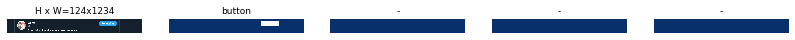

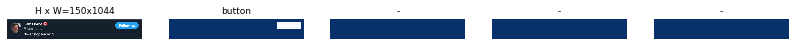

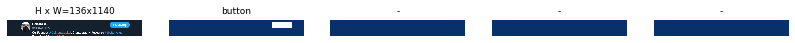

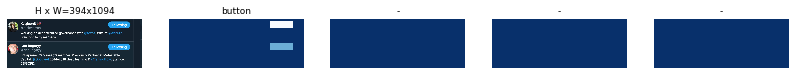

In [12]:
# Load and display random samples

image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [13]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [14]:
# Select the pre-trained weights. 
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training 


Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. Simply pass `layers="all` to train all layers.

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head layers. 
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

# Fine tune all layers
# Passing layers="all" trains all layers. 
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/Twitter_button/button_logs/button20200206T1633/mask_rcnn_button_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

## Detection

In [16]:
class InferenceConfig(ButtonConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/Mask_RCNN/Twitter_button/button_logs/button20200206T1633/mask_rcnn_button_0002.h5
Re-starting from epoch 2


Processing 1 images
image                    shape: (1766, 1372, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1766.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


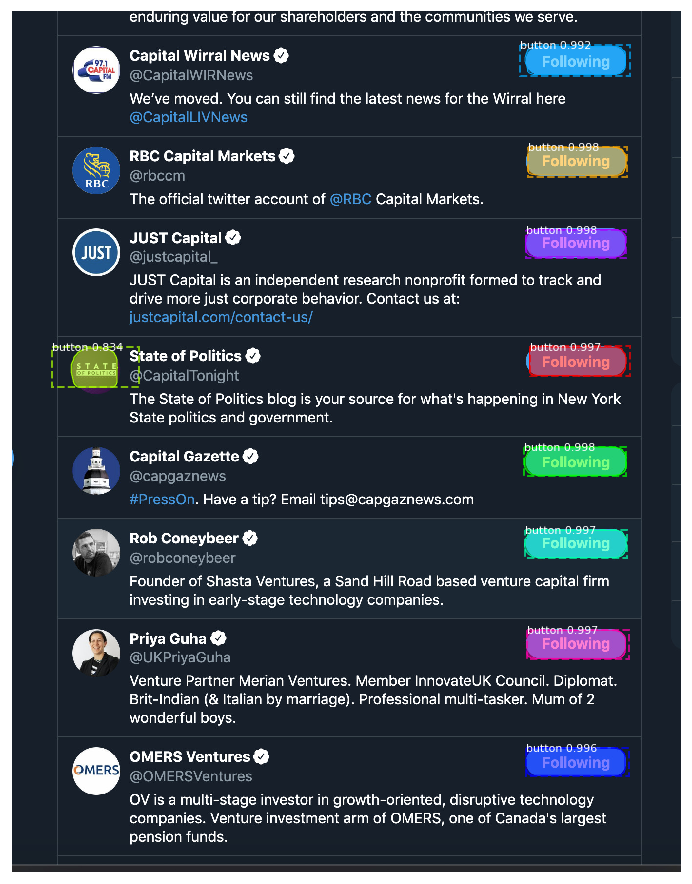

In [17]:
# Test on the testing image without annotations. And print out the bounding boxes. 
class_names = ['BG', 'button']

image_path = os.path.join(DATASETS_DIR, "test/5.jpg")
image = skimage.io.imread(image_path)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [18]:
print("The bounding boxes positions are:")
print("[N, [y1, x1, y2, x2]]")
print(r['rois'])

The bounding boxes positions are:
[N, [y1, x1, y2, x2]]
[[ 278 1060  338 1262]
 [ 447 1055  505 1260]
 [ 893 1052  952 1261]
 [ 687 1063  748 1268]
 [1270 1058 1328 1267]
 [1063 1053 1121 1262]
 [1511 1056 1568 1266]
 [  67 1044  131 1268]
 [ 688   83  771  261]]
